In [1]:
library(tidyverse)
library(ggbeeswarm)
library(ggpubr)
library(SingleCellExperiment)
#library(xbioc)
library(MuSiC)
library(Seurat)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, c

In [2]:
SC.eset <- readRDS('/lustre/scratch117/cellgen/team205/rl20/CTCL/object-new/CTCL1-8_ExpressionSet_for_deconv_down0.2.rds')
SC.eset

ExpressionSet (storageMode: lockedEnvironment)
assayData: 27455 features, 55815 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: AAACCTGAGAATGTTG-1 AAACCTGAGTTCGCAT-1 ...
    TTTGTCATCTTGTATC-1-40 (55815 total)
  varLabels: donor_id broad_cell_type anno
  varMetadata: labelDescription
featureData: none
experimentData: use 'experimentData(object)'
Annotation:  

In [3]:
table(phenoData(SC.eset)$broad_cell_type)
#T-cell includes T, ILC and NK


       APC   B/plasma      Fibro         KC     L-Endo       Mast Melanocyte 
      6652       1215       4710       7496        420        417       1187 
  Pericyte     T-cell     V-Endo 
      1837      28573       3308 

In [4]:
#Bulk.eset <- readRDS('/lustre/scratch117/cellgen/team205/rl20/CTCL/deconvolution/GSE121212_readcount_ExpressionSet.rds') ## healthy skin, AD and psoriasis
Bulk.eset <- readRDS('/home/jovyan/farm/CTCL/deconvolution/CTCL-PKU_ExpressionSet.rds')
Bulk.eset

ExpressionSet (storageMode: lockedEnvironment)
assayData: 33216 features, 49 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: B266 B355 ... N69 (49 total)
  varLabels: condition
  varMetadata: labelDescription
featureData
  featureNames: METTL25 LINC01742 ... INVS (33216 total)
  fvarLabels: gene_name
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'
Annotation:  

In [5]:
SC.basis <- music_basis(SC.eset, clusters = 'broad_cell_type', samples = 'donor_id')

Creating Relative Abundance Matrix...

Creating Variance Matrix...

Creating Library Size Matrix...



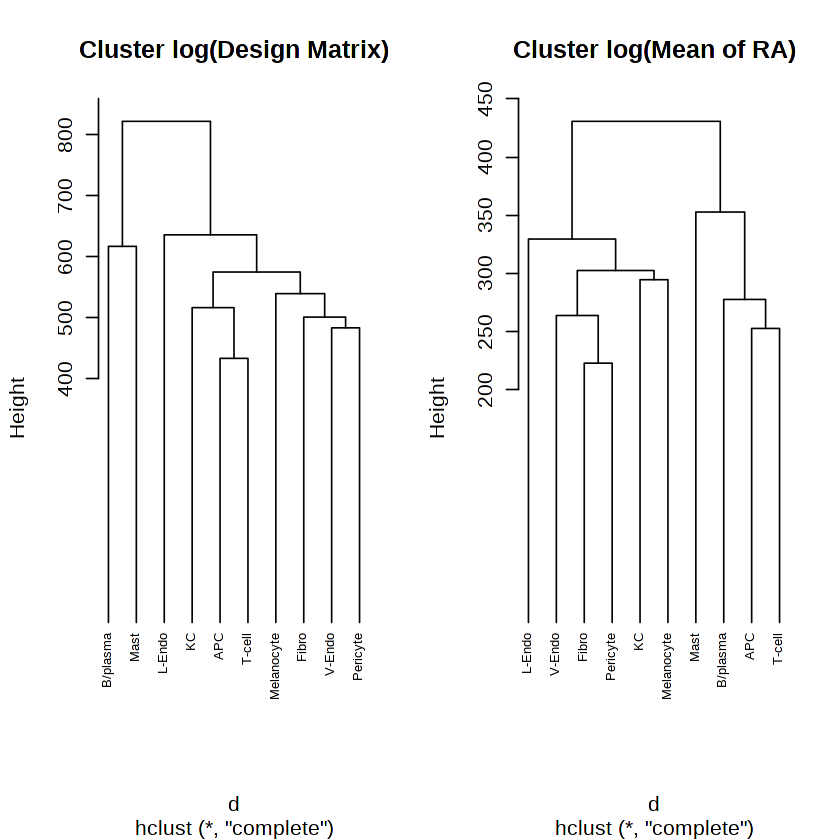

In [6]:
par(mfrow = c(1, 2))
d <- dist(t(log(SC.basis$Disgn.mtx + 1e-6)), method = "euclidean")
# Hierarchical clustering using Complete Linkage
hc1 <- hclust(d, method = "complete" )
# Plot the obtained dendrogram
plot(hc1, cex = 0.6, hang = -1, main = 'Cluster log(Design Matrix)')
d <- dist(t(log(SC.basis$M.theta + 1e-8)), method = "euclidean")
# Hierarchical clustering using Complete Linkage
# hc2 <- hclust(d, method = "complete" )
hc2 <- hclust(d, method = "complete")
# Plot the obtained dendrogram
plot(hc2, cex = 0.6, hang = -1, main = 'Cluster log(Mean of RA)')

In [7]:
clusters.type = list(C1 = c('B/plasma', 'Mast', 'T-cell', 'APC'), 
                     C2 = c('KC', 'L-Endo', 'V-Endo','Fibro','Pericyte','Melanocyte'))

#clusters.type = list(C1 = c('Treg','T-cell'), 
#                     C2 = c('APC', 'B/plasma','Mast'),
#                     C3 = c('KC', 'L-Endo', 'V-Endo','Fibro','Pericyte','Melanocyte'))

cl.type = as.character(SC.eset$broad_cell_type)


for(cl in 1:length(clusters.type)){
  cl.type[cl.type %in% clusters.type[[cl]]] = names(clusters.type)[cl]
}
pData(SC.eset)$clusterType = factor(cl.type, levels = c(names(clusters.type)))

# 13 selected cell types
s.SC <- unlist(clusters.type)
s.SC

C11          C12          C13          C14          C21          C22 
  "B/plasma"       "Mast"     "T-cell"        "APC"         "KC"     "L-Endo" 
         C23          C24          C25          C26 
    "V-Endo"      "Fibro"   "Pericyte" "Melanocyte"

In [12]:
seurat_object <- readRDS("/lustre/scratch117/cellgen/team205/rl20/CTCL/object-new/CTCL1-8_raw_downsample0.2_anno_for_deconv.rds")
seurat_object

An object of class Seurat 
33538 features across 55815 samples within 1 assay 
Active assay: RNA (33538 features, 0 variable features)

In [16]:
seurat_object <- NormalizeData(seurat_object, normalization.method = "LogNormalize", scale.factor = 10000)

In [17]:
names(clusters.type)

[1] "C1" "C2"

In [18]:
Idents(seurat_object) <- 'broad_cell_type'

temp <- subset(seurat_object, id = clusters.type$C1)
C1_genes <- FindAllMarkers(temp, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25, min.diff.pct = 0.25)
temp <- subset(seurat_object, id = clusters.type$C2)
C2_genes <- FindAllMarkers(temp, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25, min.diff.pct = 0.25)
#temp <- subset(seurat_object, id = clusters.type$C3)
#C3_genes <- FindAllMarkers(temp, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25, min.diff.pct = 0.25)
#temp <- subset(seurat_object, id = clusters.type$C4)
#C4_genes <- FindAllMarkers(temp, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25, min.diff.pct = 0.25)


Calculating cluster APC

Calculating cluster T-cell

Calculating cluster B/plasma

Calculating cluster Mast

Calculating cluster KC

Calculating cluster Fibro

Calculating cluster Melanocyte

Calculating cluster V-Endo

Calculating cluster L-Endo

Calculating cluster Pericyte



In [19]:
#diff_genes<-list((C1_genes %>% group_by(cluster) %>% slice_max(order_by = avg_log2FC, n = 20))$gene,
#                 (C2_genes %>% group_by(cluster) %>% slice_max(order_by = avg_log2FC, n = 20))$gene,
#                 (C3_genes %>% group_by(cluster) %>% slice_max(order_by = avg_log2FC, n = 20))$gene,
#                 (C4_genes %>% group_by(cluster) %>% slice_max(order_by = avg_log2FC, n = 20))$gene)
diff_genes <- list((C1_genes %>% group_by(cluster) %>% slice_max(order_by = avg_log2FC, n = 20))$gene,
                   (C2_genes %>% group_by(cluster) %>% slice_max(order_by = avg_log2FC, n = 20))$gene)
names(diff_genes)<-c('C1', 'C2')

In [20]:
saveRDS(diff_genes, file = "/home/jovyan/farm/CTCL/deconvolution_new/deconv_DEGs_donw0.2.rds")

In [8]:
diff_genes <- readRDS('/home/jovyan/farm/CTCL/deconvolution_new/deconv_DEGs_donw0.2.rds')
diff_genes

$C1
 [1] "CCL22"    "CST3"     "HLA-DRA"  "TXN"      "CXCL8"    "HLA-DPB1"
 [7] "HLA-DPA1" "HLA-DRB1" "C15orf48" "TYROBP"   "IDO1"     "HLA-DRB5"
[13] "HLA-DQA1" "LYZ"      "CCL17"    "G0S2"     "HLA-DQB1" "SAT1"    
[19] "CD83"     "TIMP1"    "IL32"     "CD7"      "ZFP36L2"  "CD3E"    
[25] "PTPRC"    "IFITM1"   "TRBC2"    "LEPROTL1" "BATF"     "EML4"    
[31] "CD3D"     "SPOCK2"   "FYN"      "CD2"      "LCK"      "CD247"   
[37] "FYB1"     "ARHGDIB"  "IL7R"     "TSC22D3"  "IGLV3-21" "IGKC"    
[43] "IGKV3-20" "IGHG1"    "IGHG4"    "IGLC2"    "IGLV3-1"  "IGHG2"   
[49] "IGHA1"    "IGHG3"    "IGLC3"    "IGLL5"    "MZB1"     "CD79A"   
[55] "JCHAIN"   "MS4A1"    "DERL3"    "GNG7"     "PRDX4"    "MEF2C"   
[61] "TPSAB1"   "TPSB2"    "HPGD"     "CPA3"     "GLUL"     "HPGDS"   
[67] "KIT"      "IL1RL1"   "FCER1G"   "CST3"     "ATP6V1G1" "COX7A2"  
[73] "NDUFA4"   "UQCRH"    "DAZAP2"   "SEPT7"    "ELOB"     "COX8A"   
[79] "EIF3K"    "TMEM50A" 

$C2
  [1] "S100A2"   "KRT14"    "S100A8"   "KRT17"    "KRT16"    "SFN"     
  [7] "KRT6A"    "KRT5"     "S100A9"   "SBSN"     "KRTDAP"   "S100A14" 
 [13] "S100A7"   "LGALS7B"  "PERP"     "TACSTD2"  "DMKN"     "KRT6B"   
 [19] "LY6D"     "LGALS7"   "CFD"      "DCN"      "TNFAIP6"  "CCL19"   
 [25] "CXCL14"   "COL1A1"   "LUM"      "G0S2"     "APOD"     "COL3A1"  
 [31] "COL1A2"   "SFRP2"    "C1S"      "COL6A2"   "MMP2"     "CLU"     
 [37] "CCDC80"   "C3"       "MFAP4"    "SERPINF1" "PMEL"     "TYRP1"   
 [43] "DCT"      "MLANA"    "NOV"      "QPCT"     "CYB561A3" "TYR"     
 [49] "FRZB"     "CAPN3"    "CDC42EP3" "TRPM1"    "KIT"      "PLP1"    
 [55] "MFSD12"   "GPR143"   "C4orf48"  "MITF"     "OSTM1"    "RAB32"   
 [61] "TM4SF1"   "SERPINE1" "PLVAP"    "DEPP1"    "SPARCL1"  "RCAN1"   
 [67] "PECAM1"   "CLDN5"    "SELE"     "ENG"      "HMOX1"    "PRSS23"  
 [73] "CALCRL"   "ESAM"     "GNG11"    "TSC22D1"  "PNP"      "ADGRL4"  
 [79] "EGFL7"    "EMCN"     "CCL21"    "TFF3"     "FABP4"    "MMRN1"   
 [85] "ANGPT2"   "CCL2"     "TFPI"     "PPFIBP1"  "C2CD4B"   "CLDN5"   
 [91] "RAMP2"    "LAPTM5"   "CD200"    "LYVE1"    "GNG11"    "PDPN"    
 [97] "EGFL7"    "SNCG"     "CAVIN2"   "PLA1A"    "RGS5"     "TAGLN"   
[103] "ACTA2"    "TPM2"     "MYL9"     "NDUFA4L2" "CPE"      "ADIRF"   
[109] "GJA4"     "TFPI"     "CALD1"    "MGP"      "KCNE4"    "ADAMTS1" 
[115] "NR2F2"    "MYH11"    "ADAMTS4"  "MFGE8"    "C11orf96" "MCAM"

In [9]:
Est.prop.precluster  <- music_prop.cluster(bulk.eset = Bulk.eset, 
                                           sc.eset = SC.eset, 
                                           group.markers = diff_genes,
                                           clusters = 'broad_cell_type', groups = 'clusterType', 
                                           samples = 'donor_id', clusters.type = clusters.type)

Start: cluster estimations...

Creating Relative Abundance Matrix...

Creating Variance Matrix...

Creating Library Size Matrix...

Start: cell type estimations...

Creating Relative Abundance Matrix...

Creating Variance Matrix...

Creating Library Size Matrix...

Used 26397 common genes...

B266 has common genes 22530 ...

B355 has common genes 22601 ...

B470 has common genes 22187 ...

B520-2 has common genes 22598 ...

L107 has common genes 20931 ...

L112 has common genes 22082 ...

L149 has common genes 22962 ...

L168 has common genes 22568 ...

L176 has common genes 22711 ...

L236 has common genes 22192 ...

L25 has common genes 22413 ...

L260 has common genes 22089 ...

L262 has common genes 20922 ...

L268 has common genes 21728 ...

L284 has common genes 22166 ...

L314 has common genes 23267 ...

L318 has common genes 22318 ...

L321 has common genes 22109 ...

L381 has common genes 21930 ...

L407 has common genes 22343 ...

L40 has common genes 22122 ...

L431 has comm

In [10]:
saveRDS(Est.prop.precluster, '/home/jovyan/farm/CTCL/deconvolution_new/Deconv_PKU_CTCLsc_precluster_0.2.rds')


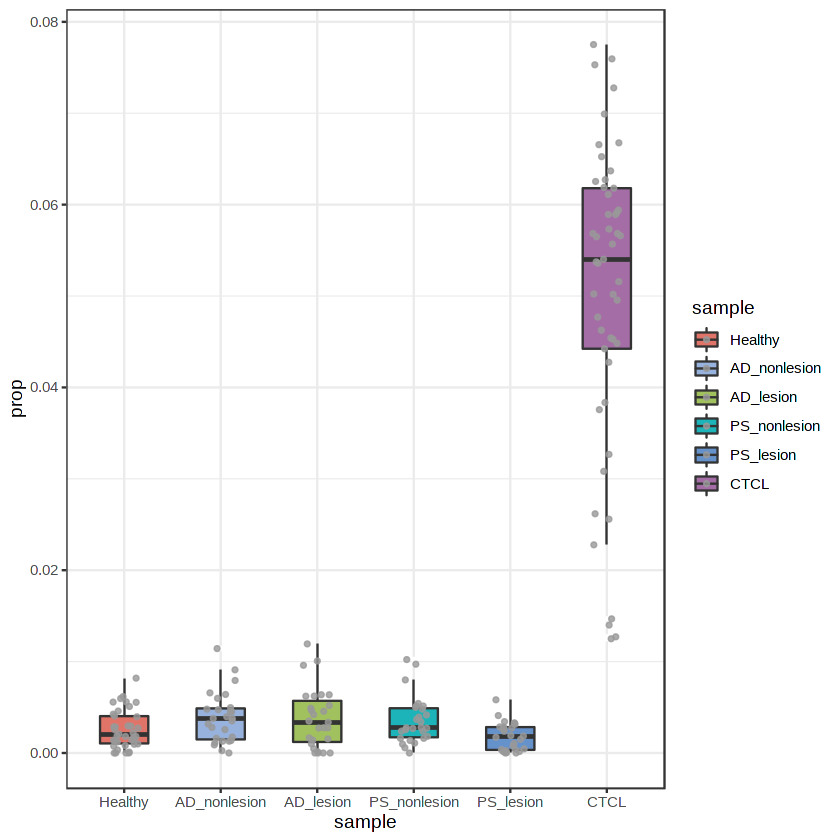

In [15]:
Est_1 <- readRDS('/home/jovyan/farm/CTCL/deconvolution_new/Deconv_GSE121212_CTCLsc_precluster.rds')
Est_2 <- readRDS('/home/jovyan/farm/CTCL/deconvolution_new/Deconv_PKU_CTCLsc_precluster_0.2.rds')

celltype <- "B/plasma"
Est_1_B <- data.frame(prop = Est_1$Est.prop.weighted.cluster[, celltype], sample = "Healthy")
Est_1_B[grep('^AD.*non-lesional$', rownames(Est_1_B)), 'sample'] <- 'AD_nonlesion'
Est_1_B[grep('^AD.*_lesional$', rownames(Est_1_B)), 'sample'] <- 'AD_lesion'
Est_1_B[grep('^AD.*_chronic_lesion$', rownames(Est_1_B)), 'sample'] <- 'AD_lesion'
Est_1_B[grep('^PSO.*non-lesional$', rownames(Est_1_B)), 'sample'] <- 'PS_nonlesion'
Est_1_B[grep('^PSO.*_lesional$', rownames(Est_1_B)), 'sample'] <- 'PS_lesion'


#celltype <- "B/plasma"
Est_2_B <- data.frame(prop = Est_2$Est.prop.weighted.cluster[, celltype], sample = "CTCL")

Est <- rbind(Est_1_B, Est_2_B)
Est$sample <- factor(Est$sample, levels = c('Healthy', 'AD_nonlesion', 'AD_lesion',
                                            'PS_nonlesion', 'PS_lesion','CTCL'))

ggplot(data = Est,aes(x = sample, y = prop, fill = sample))+
  geom_boxplot(aes(group=sample), width=0.5, outlier.colour = "white", outlier.size = 0.5)+
  geom_point(position=position_jitter(width = 0.15,height = 0),alpha=0.8,shape=19, color = 'grey60', size = 1)+
  #geom_quasirandom(method = "quasirandom", dodge.width=0.8, size=1.2, shape=20, alpha=1) +
  scale_fill_manual(values = c("#E07469","#97B2DD", "#A1C15F","#1CB4B8", "#6692CC","#A46DA6")) +
theme_bw()

#### Prognosis data

In [16]:
data <- read.table("/home/jovyan/farm/CTCL/deconvolution/PKU_metadata_PFS_OS.xls", header = T)
data <- data[,1:9]

In [17]:
data %>% head()

,Patient,Sex,Age,LCT,Stage,PFS_time,PFS,OS_time,OS
,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>
1,B266,F,70,no,IIB,55,1,56,1
2,B355,M,55,LCT,IIB,10,1,10,1
3,B470,M,45,no,IIB,32,0,32,0
4,L107,M,52,LCT,IIB,12,0,12,0
5,L112,M,21,LCT,IIB,4,1,22,1
6,L149,F,15,LCT,IIB,24,1,54,1


In [18]:
Est <- readRDS('/home/jovyan/farm/CTCL/deconvolution_new/Deconv_PKU_CTCLsc_precluster_0.2.rds')
Est_prop <- Est$Est.prop.weighted.cluster
Est_prop <- Est_prop[-which(rownames(Est_prop)=="B520-2"), ]
Est_prop %>% head()

,B/plasma,Mast,T-cell,APC,KC,L-Endo,V-Endo,Fibro,Pericyte,Melanocyte
B266,0.03267274,0.006290670,0.2981468,0.07975009,0.24109682,0.013626401,0.09575007,0.14193839,0.05267313,0.03805486
B355,0.05659856,0.010472601,0.4971731,0.13285841,0.12527323,0.007073884,0.04973246,0.07371274,0.02733360,0.01977137
B470,0.04769366,0.008920078,0.4218401,0.11276148,0.16897653,0.009551941,0.06711907,0.09952323,0.03694115,0.02667279
L107,0.06369207,0.011652302,0.5541895,0.14808824,0.09203555,0.005187040,0.03650510,0.05409523,0.02003212,0.01452288
L112,0.06111063,0.011113733,0.5275993,0.14089140,0.10729048,0.006051982,0.04257591,0.06310916,0.02338467,0.01687269
L149,0.05941017,0.011038481,0.5195103,0.13884022,0.11218122,0.006330495,0.04452348,0.06600181,0.02445939,0.01770446


In [19]:
Est_prop <- Est_prop[data$Patient, ]

In [20]:
data_prop <- cbind(data, Est_prop)
data_prop %>% head()

,Patient,Sex,Age,LCT,Stage,PFS_time,PFS,OS_time,OS,B/plasma,Mast,T-cell,APC,KC,L-Endo,V-Endo,Fibro,Pericyte,Melanocyte
,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
B266,B266,F,70,no,IIB,55,1,56,1,0.03267274,0.006290670,0.2981468,0.07975009,0.24109682,0.013626401,0.09575007,0.14193839,0.05267313,0.03805486
B355,B355,M,55,LCT,IIB,10,1,10,1,0.05659856,0.010472601,0.4971731,0.13285841,0.12527323,0.007073884,0.04973246,0.07371274,0.02733360,0.01977137
B470,B470,M,45,no,IIB,32,0,32,0,0.04769366,0.008920078,0.4218401,0.11276148,0.16897653,0.009551941,0.06711907,0.09952323,0.03694115,0.02667279
L107,L107,M,52,LCT,IIB,12,0,12,0,0.06369207,0.011652302,0.5541895,0.14808824,0.09203555,0.005187040,0.03650510,0.05409523,0.02003212,0.01452288
L112,L112,M,21,LCT,IIB,4,1,22,1,0.06111063,0.011113733,0.5275993,0.14089140,0.10729048,0.006051982,0.04257591,0.06310916,0.02338467,0.01687269
L149,L149,F,15,LCT,IIB,24,1,54,1,0.05941017,0.011038481,0.5195103,0.13884022,0.11218122,0.006330495,0.04452348,0.06600181,0.02445939,0.01770446


In [21]:
colnames(data_prop) <- c(colnames(data_prop)[1:9],'B_plasma','Mast','T-cell','APC',
                         'KC','L-Enod','V-Endo','Fibro','Pericyte','Melanocyte')

In [22]:
library(survival)
library(survminer)
library(survMisc)
library(RColorBrewer)


Attaching package: ‘survMisc’


The following object is masked from ‘package:ggplot2’:

    autoplot




In [23]:
cut <- cutp(coxph(Surv(PFS_time, PFS)~Stage+Age+strata(Sex)+B_plasma, data=data_prop))$B_plasma[]
cut %>% head()

B_plasma,U,Q,p
<dbl>,<dbl>,<dbl>,<dbl>
0.05018188,5.517209,1.289392,0.07193715
0.05157684,5.195580,1.214226,0.10480159
0.04954702,4.714282,1.101745,0.17636079
0.04625969,4.664379,1.090082,0.18559038
0.05659856,4.659840,1.089022,0.18644826
0.05022571,4.559319,1.065530,0.20625127


In [24]:
data_prop$tx <- rep(NA, nrow(data_prop))
data_prop$tx[which(data_prop$B_plasma < 0.05018188)] <- 1
#data$tx[which(data$B_plasma >= 0.027831 & data$B_plasma < 0.094703)] <- 2
data_prop$tx[which(data_prop$B_plasma >= 0.05018188)] <- 2

[1] 19

[1] 29

Call:
coxph(formula = Surv(PFS_time, as.numeric(PFS)) ~ tx + Stage + 
    Age + strata(Sex), data = data_prop)

  n= 48, number of events= 22 

              coef exp(coef) se(coef)     z Pr(>|z|)  
tx        1.552417  4.722870 0.686283 2.262   0.0237 *
StageIIIA 1.116032  3.052718 1.235162 0.904   0.3662  
StageIIIB 0.559819  1.750355 1.111970 0.503   0.6146  
StageIVA2 1.129441  3.093925 0.615224 1.836   0.0664 .
StageIVB  0.314015  1.368911 1.061637 0.296   0.7674  
Age       0.006793  1.006816 0.015330 0.443   0.6577  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

          exp(coef) exp(-coef) lower .95 upper .95
tx            4.723     0.2117    1.2304    18.129
StageIIIA     3.053     0.3276    0.2712    34.360
StageIIIB     1.750     0.5713    0.1980    15.475
StageIVA2     3.094     0.3232    0.9265    10.332
StageIVB      1.369     0.7305    0.1709    10.966
Age           1.007     0.9932    0.9770     1.038

Concordance= 0.688  (se = 0.066 )
Likelihood 

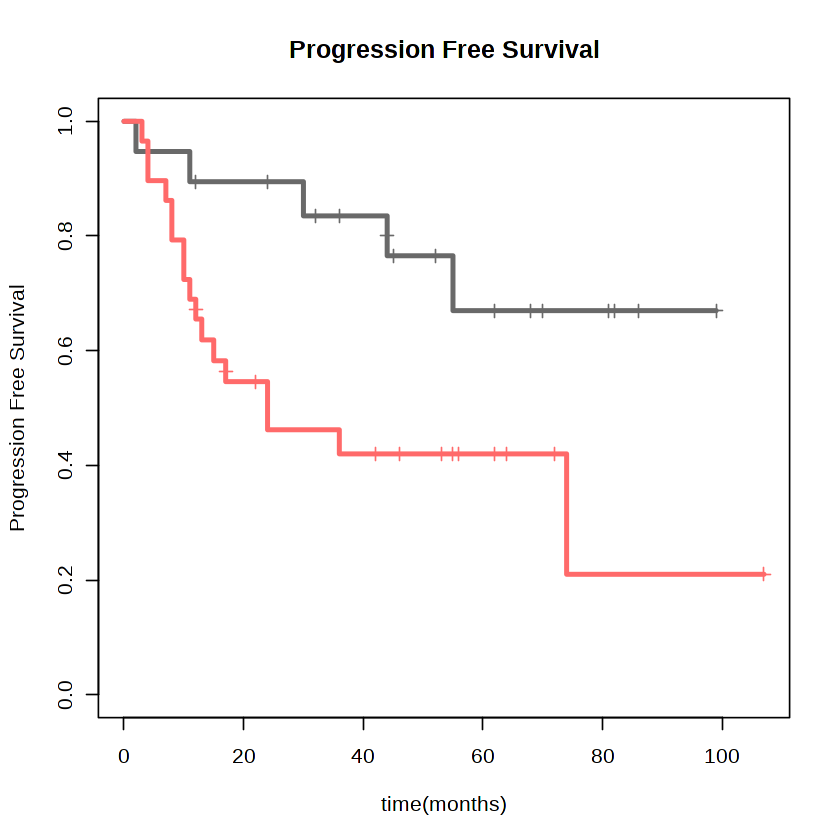

In [25]:
sd <- survfit(Surv(PFS_time, as.numeric(PFS))~tx, data=data_prop, se.fit=T, conf.int=.95,type="kaplan-meier")
#ggsurvplot(sd, data=data, conf.int = TRUE, palette = c("dodgerblue3","red2"))

SD <- coxph(Surv(PFS_time,as.numeric(PFS))~tx+Stage+Age+strata(Sex),data=data_prop)
plot(sd, lty=1, lwd=3, col=c("DimGrey", "IndianRed1"),
     mark.time=T, xlab="time(months)",ylab="Progression Free Survival",main="Progression Free Survival")

sum(data_prop$tx==1)
sum(data_prop$tx==2)

summary(SD)